In [1]:
import sys
sys.path.append('/auto/home/filya/3DMolGen')
import os
import numpy as np
import datamol as dm
from rdkit import Chem
import os.path as osp
import ast
from loguru import logger as log
from tqdm import tqdm  
from molgen3D.data_processing.preprocessing_forked_ET_Flow import load_pkl, load_json, embed_coordinates, embed_coordinates_spherical
from molgen3D.evaluation.inference import parse_molecule_with_coordinates
from get_cartesian_from_spherical import parse_molecule_with_spherical_coordinates
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

embedding_func_selector = {
    "cartesian": embed_coordinates,
    "spherical": embed_coordinates_spherical
}
decoding_func_selector = {
    "cartesian": parse_molecule_with_coordinates,
    "spherical": parse_molecule_with_spherical_coordinates
}

def validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision):
    partitions = ["qm9"]
    rmsds = []
    embedding_function = embedding_func_selector[embedding_type]
    decoding_function = decoding_func_selector[embedding_type]
    writer = Chem.SDWriter("special_mol.sdf")
    writer1 = Chem.SDWriter("special-rec.sdf")

    for partition in partitions:
        # dest_path = osp.join(dest_folder_path, partition.upper())
        # train_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                                 "train_indices.npy"]), allow_pickle=True)))
        # val_indices = set(sorted(np.load(osp.join(*[indices_path, partition.upper(),
        #                                             "val_indices.npy"]), allow_pickle=True)))
        # log.info(f"{partition} indices contain train:{len(train_indices)}, valid:{len(val_indices)},"\
        #             f" total:{len(train_indices)+len(val_indices)} samples")
        mols = load_json(osp.join(raw_path, f"summary_{partition}.json"))
        for id, (mol_id, mol_dict) in tqdm(
            enumerate(mols.items()),
            total=len(mols),
            desc=f"Processing molecules of {partition}",
        ):
            if id >= limit:
                break
            mol_pickle = load_pkl(os.path.join(raw_path, mol_dict["pickle_path"]))
            confs = mol_pickle["conformers"]       
            try: 
                for conf in confs:
                    mol, geom_id = conf["rd_mol"], conf["geom_id"]
                    canonical_smiles = dm.to_smiles(
                        mol,
                        canonical=True,
                        explicit_hs=True,
                        with_atom_indices=False,
                        isomeric=False,
                    )
                    if '.' in canonical_smiles:
                        continue
                    atom_order = list(map(int, ast.literal_eval(mol.GetProp('_smilesAtomOutputOrder'))))
                    embedded_smiles = embedding_function(mol, canonical_smiles, atom_order, precision)
                    
                    # sample = {"canonical_smiles": canonical_smiles,
                    #             "geom_embed_coordinatesid": geom_id, 
                    #             "embedded_smiles": embedded_smiles}
                    mol1 = decoding_function(embedded_smiles)
                    rmsd = AllChem.GetBestRMS(mol, mol1)
                    rmsds.append(rmsd)
                    if rmsd > 1:
                        writer.write(mol)
                        writer1.write(mol1)
                    #     log.info(canonical_smiles)
                    #     log.info(len(confs))
                        log.info(id)
                        log.info(rmsd)

            except Exception as e:
                log.error(f"Error: {e} for molecule {mol_id}")
    
    writer.close()
    writer1.close()

    rmsds = np.array(rmsds)
    return rmsds

def stat_log(rmsds):
    max_rmsd = np.max(rmsds)
    mean_rmsd = np.mean(rmsds)
    percentile95 = np.percentile(rmsds, 95)
    log.info(f"Maximum RMSD: {max_rmsd}")
    log.info(f"Mean RMSD: {mean_rmsd}")
    log.info(f"95th Percentile: {percentile95}")
    plt.figure(figsize=(8, 6))
    plt.hist(rmsds, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.xlabel("RMSD")
    plt.ylabel("Frequency")
    plt.title("Distribution of RMSDs")
    plt.show()


/auto/home/filya/miniforge/envs/titan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Processing molecules of qm9:   0%|          | 0/133258 [00:00<?, ?it/s]2025-03-04 19:54:15.748 | ERROR    | __main__:validate:82 - Error: ('f,c1,i are collinear in atom', 0) for molecule C#C
2025-03-04 19:54:15.751 | ERROR    | __main__:validate:82 - Error: ('f,c1,i are collinear in atom', 0) for molecule C#CC#C
Processing molecules of qm9:   1%|          | 980/133258 [00:36<33:30, 65.79it/s]  2025-03-04 19:54:51.986 | INFO     | __main__:validate:78 - 994
2025-03-04 19:54:51.986 | INFO     | __main__:validate:79 - 1.569665950762992
Processing molecules of qm9:   1%|          | 1000/133258 [00:36<1:19:59, 27.56it/s]
2025-03-04 19:54:52.032 | INFO     | __main__:stat_log:94 - Maximum RMSD: 0.13701290148369868
2025-03-04 19:54:52.033 | INFO     | __main__:stat_log:95 - Mean RMSD: 0.00019706210793794023
2025-03-04 19:54:52.033 | INFO     | __main__:stat_log:96 - 95th Percentile: 0.00037824667840332483


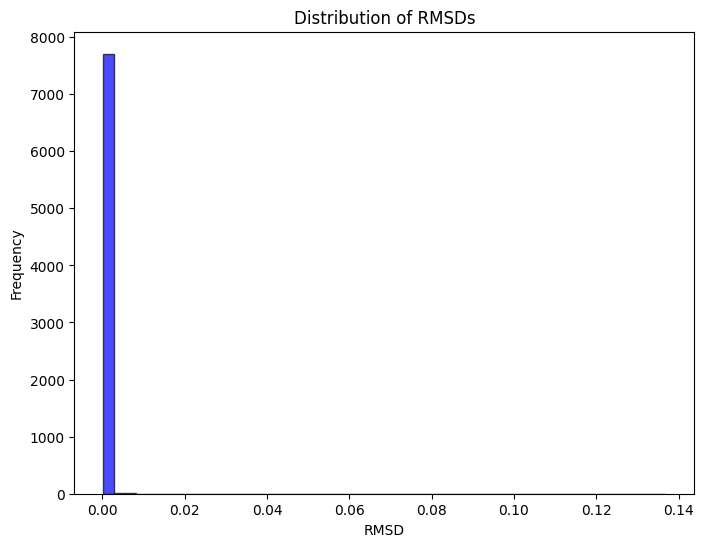

In [ ]:
import numpy as np

# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
dest_folder_path = "geom"
os.makedirs(dest_folder_path, exist_ok=True)

indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 1000

rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=4)
stat_log(np.sort(rmsds)[:-1])

Processing molecules of qm9:   0%|          | 0/133258 [00:00<?, ?it/s]2025-03-04 19:55:30.268 | ERROR    | __main__:validate:82 - Error: ('f,c1,i are collinear in atom', 0) for molecule C#C
2025-03-04 19:55:30.270 | ERROR    | __main__:validate:82 - Error: ('f,c1,i are collinear in atom', 0) for molecule C#CC#C
Processing molecules of qm9:   0%|          | 100/133258 [00:00<21:36, 102.70it/s]
2025-03-04 19:55:31.256 | INFO     | __main__:stat_log:94 - Maximum RMSD: 0.1292145824278283
2025-03-04 19:55:31.257 | INFO     | __main__:stat_log:95 - Mean RMSD: 0.0006879000092583627
2025-03-04 19:55:31.258 | INFO     | __main__:stat_log:96 - 95th Percentile: 0.00014928530864742379


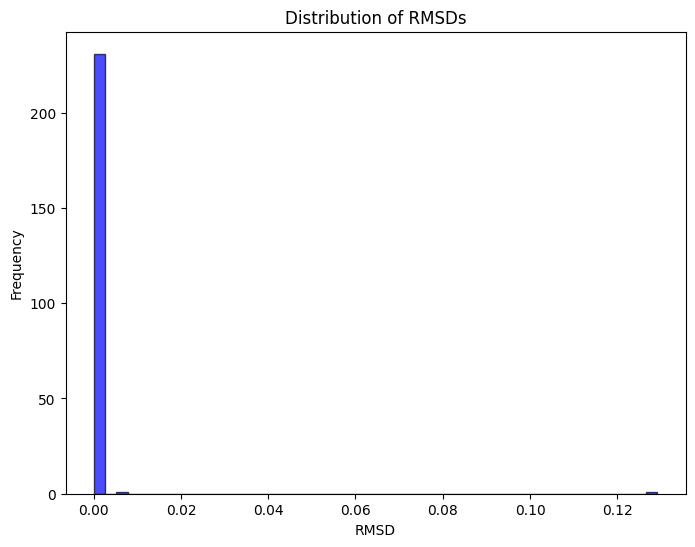

In [3]:
# Parameters for preprocessing
raw_path = "/mnt/sxtn2/chem/GEOM_data/rdkit_folder"
dest_folder_path = "geom"
os.makedirs(dest_folder_path, exist_ok=True)

indices_path = "/mnt/sxtn2/chem/GEOM_data/et_flow_indice/"
embedding_type = "spherical"
limit = 100

rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=4)

stat_log(rmsds)

Maximum RMSD: 5.9973716512789615e-05
Mean RMSD: 4.717082189365553e-05
95th Percentile: 5.2374369940001826e-05


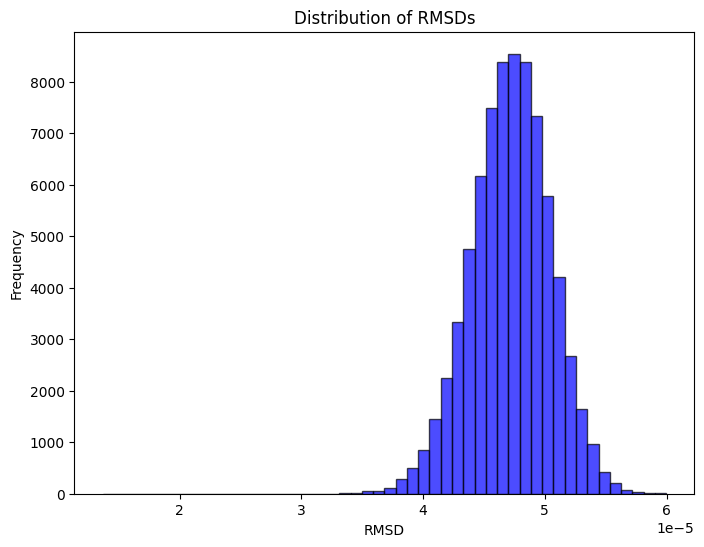

In [ ]:
stat_log(rmsds) #c4

Processing molecules of qm9:   1%|          | 745/133258 [00:02<09:22, 235.69it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 949/133258 [00:03<09:50, 223.94it/s][18:10:09] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:10:09] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1050/133258 [00:03<07:13, 304.79it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2092/133258 [00:08<02:43, 800.39it/s][18:10:14] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:10:14] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:49<21:09, 100.99it/s] 

Maximum RMSD: 0.006011901342061139
Mean RMSD: 0.004702777946379792
95th Percentile: 0.005228246823179082


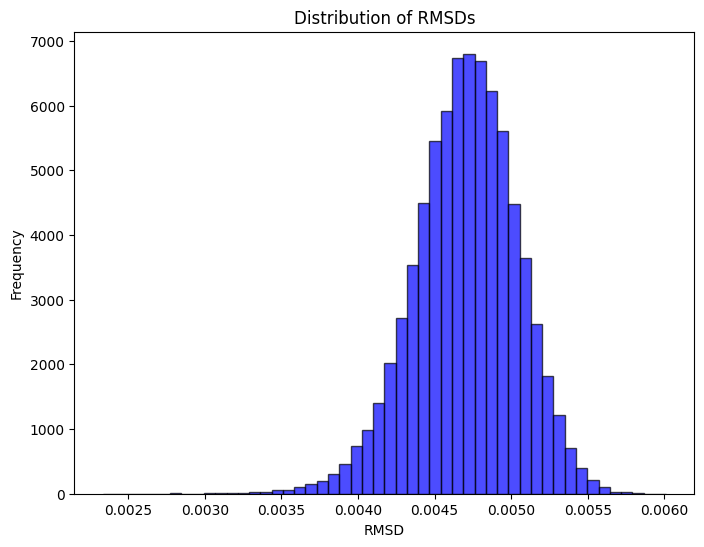

In [9]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=2)
stat_log(rmsds)

Processing molecules of qm9:   1%|          | 753/133258 [00:02<09:02, 244.34it/s]

[H][C]#[C][C](=[O])[N]=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)N=C=O.N#N


Processing molecules of qm9:   1%|          | 912/133258 [00:03<11:26, 192.69it/s][18:11:49] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:11:49] Explicit valence for atom # 7 H, 2, is greater than permitted
Processing molecules of qm9:   1%|          | 1029/133258 [00:03<06:24, 343.91it/s]

[H][C]#[C][C](=[O])[C]([H])=[C]=[O][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[CH][C][O].N#N
[H][C]#[C][C](=[O])[N]=[C]=[N][H][N]#[N]
Error: Failed to parse the extracted SMILES. for molecule C#CC(=O)[N][C][NH].N#N


Processing molecules of qm9:   2%|▏         | 2082/133258 [00:07<02:28, 884.49it/s][18:11:54] Explicit valence for atom # 7 H, 2, is greater than permitted
[18:11:54] Explicit valence for atom # 0 C, 1, is greater than permitted


[H][C]#[C][C]([H])=[C]([N]=[O])[C]([H])([H])[H][H][N]([H])[C]([H])([H])[H]
Error: Failed to parse the extracted SMILES. for molecule C#CC=C(C)[N][O].CN
[C-4][C-4][C-4][C-4][C-4][C-4][H+][H+][H+][H+][H+][H][C-3][H][C-3][H][C-3]
Error: Failed to parse the extracted SMILES. for molecule C#CCC#CC#CCC


Processing molecules of qm9:   4%|▍         | 5000/133258 [00:37<15:50, 134.89it/s] 

Maximum RMSD: 6.085108419891015e-06
Mean RMSD: 4.716564828831656e-06
95th Percentile: 5.236215178110685e-06


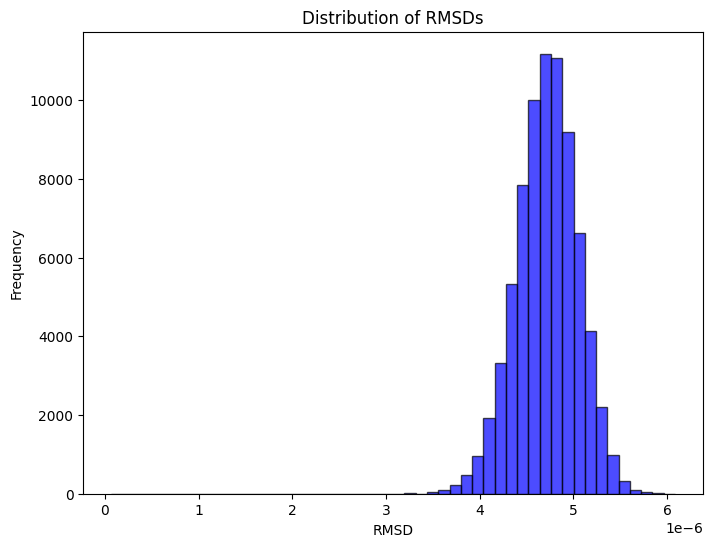

In [10]:
rmsds = validate(raw_path, dest_folder_path, indices_path, embedding_type, limit, precision=5)
stat_log(rmsds)